# GPU Programminng with `CUDA.jl`

In the previous notebook, we got our first glimpse of the `CUDA.jl` package, how
it allows us to reap the benefits of GPUs using just high level Julia code that
we already know and love, and we saw through benchmarking how much speedup this
can provide.  In this notebook we are going to recreate the `intshift` and
`intfdr` functions from an earlier notebook and the `fdshift` and `fftfdr`
functions from the previous notebook.  We will do some further benchmarking to
see how `CUDA.jl` accelerates these functions and explore peak searching
algorithms.  Finally we will do a comparison of the GPU performance of these two
techniques, integer sample shifting vs Fourier domain sample shifting, in terms
of generating frequency drift rate matrices.

Before we get into all that, it is worth repeating some of the key benefits that
`CUDA.jl` offers:

- Access to the full CUDA driver API from Julia, including asynchronous
  programming constructs such as events, streams, and graphs

- Access to many other CUDA APIs from Julia includsing cuBLAS, cuFFT, cuRAND,
  cuSparse, cuSolver, and cuDN.
  
- Ability to write and launch custom CUDA kernels using only Julia thereby
  solving the *two langauge problem*

- Ability to automatically compile and launch efficient kernels for regular
  Julia functions simply by passing a `CuArray` rather than an `Array`

The power of the last point cannot be overemphasized.  Regular Julia functions
that operate on `AbstractArray`s can be passed a `CuArray` (essentially an
`AbstractArray` subtype that is backed by memory on the GPU) and the code will
automatically run parallelized on the GPU asynchronously.  Some restrictions
apply, such as avoiding scalar indexing, but for the most part these are
actually just good Julia coding practices anyway.  Functions being run on
the GPU this way do not have to know anything about CUDA or kernels.  This
allows the exact same code to run on either CPUs or GPUs depending on the type
of `AbstractArray` being operated on (non-`CuArray` or `CuArray`).  This vastly
streamlines the development process by allowing code to be developed and tested
on non-GPU systems and then moved to GPUs without have to rewrite or retest the
core algorithms.  Not only does this sovle the two language problem, it also
solves the *two paradigm problem*.

In [1]:
# Perform some preliminary Julia setup
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
using CUDA
using FFTW
using HDF5
using BenchmarkTools
default(legend=false)
CUDA.allowscalar(false)

  Activating project at `~/JuliaDeDopplerNotebooks`


## Read in the data

We're getting good at this...

In [2]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(download(voyager_url))
full_spectrogram = h5["data"][:,1,:]
freq_range = range(659935, length=150)
spectrogram = full_spectrogram[freq_range,:]
size(spectrogram), size(full_spectrogram)

((150, 16), (1048576, 16))

## Recreate `intshift` and `intfdr`

Recreate the `intshift` and `intfdr` functions.  We have also added a mutating
`intshift!` function and given `intfdr` a 3D "work" array that gives each rate
its own work buffer to facilitate parallelizability.  We also changed `intfdr`
to use `sum!` with "views" created using the `@views` macro.

In [3]:
function intshift!(dout, din, rate)
    dout = similar(din)
    for (i, (cin, cout)) in enumerate(zip(eachcol(din), eachcol(dout)))
        n = round(rate*(i-1))
        circshift!(cout, cin, n)
    end
    return dout
end

function intshift(din, rate)
    dout = similar(din)
    intshift!(dout, din, rate)
end

function intfdr(spectrogram, rates)
    Nf, Nt = size(spectrogram)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    # Create 3D work array so that each rate will get its own work Matrix.
    # This makes it possible to paralleize the for loop.
    work = similar(spectrogram, Nf, Nt, Nr)
    for (i,r) in enumerate(rates)
        @views sum!(fdr[:,i], intshift!(work[:,:,i], spectrogram, r))
    end
    return fdr
end

intfdr (generic function with 1 method)

## Recreate the `fdshift` and `fftfdr` functions

The `fdshift` and `fftfdr` functions along with the suppoerting `phasor` methods
are recreated here essentially unchanged from the prevous notebook.

In [4]:
function phasor(k,n,r,N)
    exp(-2im*π*k*n*r/N)
end

function phasor(i::CartesianIndex, r, N)
    phasor(i[1]-1, i[2]-1, r, N)
end

function fdshift!(dest::AbstractVector{<:Real}, spectrogram::AbstractMatrix{<:Real}, rate)
    Nf = size(spectrogram, 1)
    @assert length(dest) == Nf "Incorrect destination size"

    # Calculate real FFT of spectrogram to get into the Fourier domain
    fd = rfft(spectrogram, 1)

    # Multiply the fourier domain spectra by the dopper rate phasors.  Notice
    # how we broadcast the `phasor`` call over the `CatersianIndices` of `fd` as
    # well as broadcast the `*=`` multiply-assignment operator.  This allows
    # Julia to fuse these operations so we avoid having to allocate and store
    # intermediate results. 
    fd .*= phasor.(CartesianIndices(fd), rate, Nf)

    # Sum over time in the Fourier domain
    fdsum = sum(fd, dims=2)

    # Store the backwards real FFT of `fdsum` into `dest`.
    # Annoyingly, there is not `bffrt!` function in Julia's `AbstractFFTs` or
    # `FFTW` package so we have to use `brfft`, which allocates, and then use
    # broadcast assignment to store the output into `dest`.
    #brfft!(dest, fdsum)
    dest .= brfft(fdsum, Nf)
end

function fftfdr(spectrogram, rates)
    Nf = size(spectrogram, 1)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    for (i,r) in enumerate(rates)
        fdshift!(@view(fdr[:,i]), spectrogram, r)
    end
    return fdr
end

fftfdr (generic function with 1 method)

## Verify that `intfdr` and `fftfdr` work as before

Before we benchmark CPU and GPU performance of these two functions, let's check
that the recreated versions still work.  Not much has changed with `fftfdr`, but
we did make a few significant changes to `intfdr`.

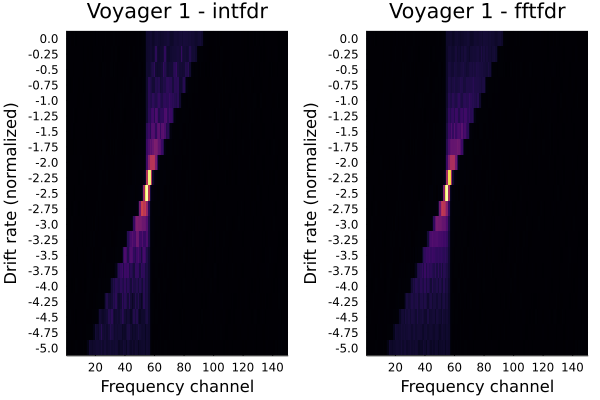

In [5]:
rates = 0:-0.25:-5
Nr = length(rates)
spectrogram_intfdr = intfdr(spectrogram, rates)
spectrogram_fftfdr = fftfdr(spectrogram, rates)
plot(
    heatmap(spectrogram_intfdr',
        title = "Voyager 1 - intfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    heatmap(spectrogram_fftfdr',
        title = "Voyager 1 - fftfdr",
        xlabel = "Frequency channel",
        ylabel = "Drift rate (normalized)",
        yflip=true, yticks=(1:Nr, rates)
    ),
    layout=(1,2)
)

Yay, they look the same as before!  Now we can move on to benchmarking.

## Benchmarking

### CPU

#### Small spectrogram

In [6]:
@benchmark intfdr($spectrogram, $rates)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  35.580 μs …   3.243 ms  ┊ GC (min … max):  0.00% … 96.03%
 Time  (median):     39.020 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   51.742 μs ± 195.731 μs  ┊ GC (mean ± σ):  23.24% ±  6.04%

       ▁▄▇█▇▅▂                                                  
  ▂▂▃▄▅███████▇▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂ ▃
  35.6 μs         Histogram: frequency by time         58.5 μs <

 Memory estimate: 408.88 KiB, allocs estimate: 24.

In [7]:
@benchmark fftfdr($spectrogram, $rates)

BenchmarkTools.Trial: 3158 samples with 1 evaluation.
 Range (min … max):  1.472 ms … 30.008 ms  ┊ GC (min … max): 0.00% … 27.30%
 Time  (median):     1.490 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.580 ms ±  1.549 ms  ┊ GC (mean ± σ):  1.61% ±  1.55%

        ▂▅██▇▆▆▄▂▂                                            
  ▂▂▂▃▅███████████▇█▆▆▅▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▂▂▂▂ ▄
  1.47 ms        Histogram: frequency by time        1.56 ms <

 Memory estimate: 361.23 KiB, allocs estimate: 1429.

#### Full spectrogram

In [8]:
@benchmark intfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  510.436 ms … 867.177 ms  ┊ GC (min … max):  9.94% … 47.00%
 Time  (median):     511.704 ms               ┊ GC (median):     9.96%
 Time  (mean ± σ):   548.116 ms ± 112.135 ms  ┊ GC (mean ± σ):  16.01% ± 11.65%

  █                                                              
  █▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  510 ms           Histogram: frequency by time          867 ms <

 Memory estimate: 2.71 GiB, allocs estimate: 46.

In [9]:
@benchmark fftfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 7.125 s (0.95% GC) to evaluate,
 with a memory estimate of 1.72 GiB, over 1535 allocations.

### GPU

In [10]:
# Create CuArrays
cu_spectrogram = CuArray(spectrogram)
cu_full_spectrogram = CuArray(full_spectrogram)
size(cu_spectrogram), size(cu_full_spectrogram)

((150, 16), (1048576, 16))

#### Small spectrogram

In [11]:
@benchmark CUDA.@sync intfdr($cu_spectrogram, $rates)

BenchmarkTools.Trial: 1458 samples with 1 evaluation.
 Range (min … max):  3.182 ms … 253.737 ms  ┊ GC (min … max): 0.00% … 56.41%
 Time  (median):     3.254 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.426 ms ±   6.560 ms  ┊ GC (mean ± σ):  2.87% ±  1.48%

            ▂▂▂▆▁▂  ▂    ▁▁▁▃▅▆█▅▄▃▅▅▄▂▇▂▁▃▁     ▃▃▅▃▄▂        
  ▃▁▃▁▃▃▄▅▄▇███████▆█▆▆▇████████████████████████▇████████▅▄▃▅ ▆
  3.18 ms         Histogram: frequency by time        3.31 ms <

 Memory estimate: 92.33 KiB, allocs estimate: 2830.

In [12]:
@benchmark CUDA.@sync intfdr($spectrogram, $rates)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  36.080 μs …   4.395 ms  ┊ GC (min … max):  0.00% … 96.25%
 Time  (median):     39.410 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   55.211 μs ± 254.220 μs  ┊ GC (mean ± σ):  27.24% ±  5.84%

        ▂▆██▆▃▁                                                 
  ▂▂▂▃▅▇███████▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂ ▃
  36.1 μs         Histogram: frequency by time           57 μs <

 Memory estimate: 408.88 KiB, allocs estimate: 24.

#### Full spectrogram

In [13]:
@benchmark CUDA.@sync intfdr($cu_full_spectrogram, $rates)

BenchmarkTools.Trial: 517 samples with 1 evaluation.
 Range (min … max):  8.794 ms … 17.175 ms  ┊ GC (min … max): 0.00% … 26.88%
 Time  (median):     8.882 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.673 ms ±  2.143 ms  ┊ GC (mean ± σ):  3.72% ±  6.28%

  █▂                                                          
  ██▇▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▆▇▇█▅▇▄▅▅▅▆ ▆
  8.79 ms      Histogram: log(frequency) by time     16.2 ms <

 Memory estimate: 90.11 KiB, allocs estimate: 2818.

In [14]:
@benchmark CUDA.@sync fftfdr($cu_full_spectrogram, $rates)

BenchmarkTools.Trial: 59 samples with 1 evaluation.
 Range (min … max):  84.094 ms … 100.565 ms  ┊ GC (min … max): 0.00% … 5.65%
 Time  (median):     84.373 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   86.154 ms ±   4.670 ms  ┊ GC (mean ± σ):  0.73% ± 1.75%

  █ ▆                                                           
  ███▅▅▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▅▅ ▁
  84.1 ms       Histogram: log(frequency) by time       100 ms <

 Memory estimate: 134.12 KiB, allocs estimate: 2828.

In [17]:
# Note sure why GPU performance of fftfdr on full_spectrum is so much worse than
# in previous notebook!??

In [18]:
# Run this cell to reclaim GPU memory from CUDA.jl's memory pool.  It's a bit of
# a funny name, because it feels more like we are releasing memory rather than
# reclaiming it, but I suppose it's all a matter of perspective.
CUDA.reclaim()